#  Glass Classification Report

## Introduction

   Glass is a ubiquitous material that can be found at most crime scenes. The classification of glass fragments is an essential aspect of forensic investigation, particularly in cases that involve broken windows, bottles and/or any other glass objects that can be found present. It can provide crucial evidence that may help investigators identify suspects or even vindicate the innocent. Glass fragments can be found on clothing and vehicles in addition to being recovered from wounds and weapons. These fragments can provide valuable clues about the source, direction and nature of the impact that led to them to break, which can be useful to investigators when reconstructing the sequence of events leading up to the crime. However, not all glass is created equal, and the classification of glass is essential to determining its origin and potential significance as well as for ruling out false matches.

   An article written by Grzegorz Zadora titled Glass analysis for forensic purposes- a comparison of classification methods states that many forensic experts analyze glass fragments under 0.5mm, therefore they must be able to accurately collect the physico-chemical features of the glass, such as Refractive Index (RI) in addition to elemental analysis. By using Scanning Electron Microscopy that has been coupled with an Energy Dispersive X-ray spectrometer (SEM-EDX), the investigators are provided with the information of major and minor elements such as Al, Mg, K, Ca and Fe. Furthermore, it is believed that obtaining the information about such elements are extremely important when comparing and individualizing the glass fragments (Zadora, G. 2007).

    #talk here about what we obtain for data results.

   The dataset used was sourced from the UCI Machine Learning Repository. The chosen dataset, Glass Identification comes from the USA Forensic Science Service and classifies 6 types of glass based on their oxide content, along with the refractive index of each glass observation. Also note that float-processing is a glass manufacturing process that creates a smooth, thick and uniform surface. In this dataset, there is no data for “vehicle_windows_non_float_processed” glass.

<b>More details on the glass identification dataset:</b>

<b>Glass Oxides (measured in weight percent)</b>
<ul>
<li>Na: Sodium</li>
<li>Mg: Magnesium</li>
<li>Al: Aluminum</li>
<li>Si: Silicon</li>
<li>K: Potassium</li>
<li>Ca: Calcium</li>
<li>Ba: Barium</li>
<li>Fe: Iron</li>
</ul>
<b>Glass Types</b>
<ul>
<li>building_windows_float_processed</li>
<li>building_windows_non_float_processed</li>
<li>vehicle_windows_float_processed</li>
<li>vehicle_windows_non_float_processed (**none in this dataset**)</li>
<li>containers</li>
<li>tableware</li>
<li>headlamps</li>
</ul>

## Methods & Results

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
install.packages("themis")
library(themis)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

#### Load data from the original source on the web 

In [32]:
dataset_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data"
col_names <- c("id", "RI", "Na", "Mg", "Al", "Si", "K", "Ca", "Ba", "Fe", "glass_type")
glass_data_raw <- read.table(dataset_url, sep =",", header = FALSE, col.names = col_names) |>
    mutate(glass_type = as_factor(glass_type))

glass_type_names <- c("building_windows_float_processed", "building_windows_non_float_processed", "vehicle_windows_float_processed", "containers", "tableware", "headlamps")
glass_data_processed <- glass_data_raw |> select(-RI)
levels(glass_data_processed$glass_type) <- glass_type_names

glass_type_counts <- glass_data_processed |>
    group_by(glass_type) |>
    summarize(count = n())

glass_type,count
<fct>,<int>
building_windows_float_processed,70
building_windows_non_float_processed,76
vehicle_windows_float_processed,17
containers,13
tableware,9
headlamps,29



### ***note: all tables and figure should have a figure/table number and a legend

#### Wrangle and clean the data from its original (downloaded) format to the format necessary for the planned analysis

#### Perform a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 

#### Create a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis

#### Perform the data analysis

! Fold1: internal:
  No observations were detected in `truth` for level(s): 'vehicle_window...
  Computation will proceed by ignoring those levels.

! Fold2: internal:
  No observations were detected in `truth` for level(s): 'tableware'
  Computation will proceed by ignoring those levels.

! Fold3: internal:
  No observations were detected in `truth` for level(s): 'tableware'
  Computation will proceed by ignoring those levels.

! Fold4: internal:
  No observations were detected in `truth` for level(s): 'containers'
  Computation will proceed by ignoring those levels.

! Fold5: internal:
  No observations were detected in `truth` for level(s): 'tableware'
  Computation will proceed by ignoring those levels.



Model,Accuracy
<chr>,<dbl>
KNN,0.6116912
Most Common,0.3636364


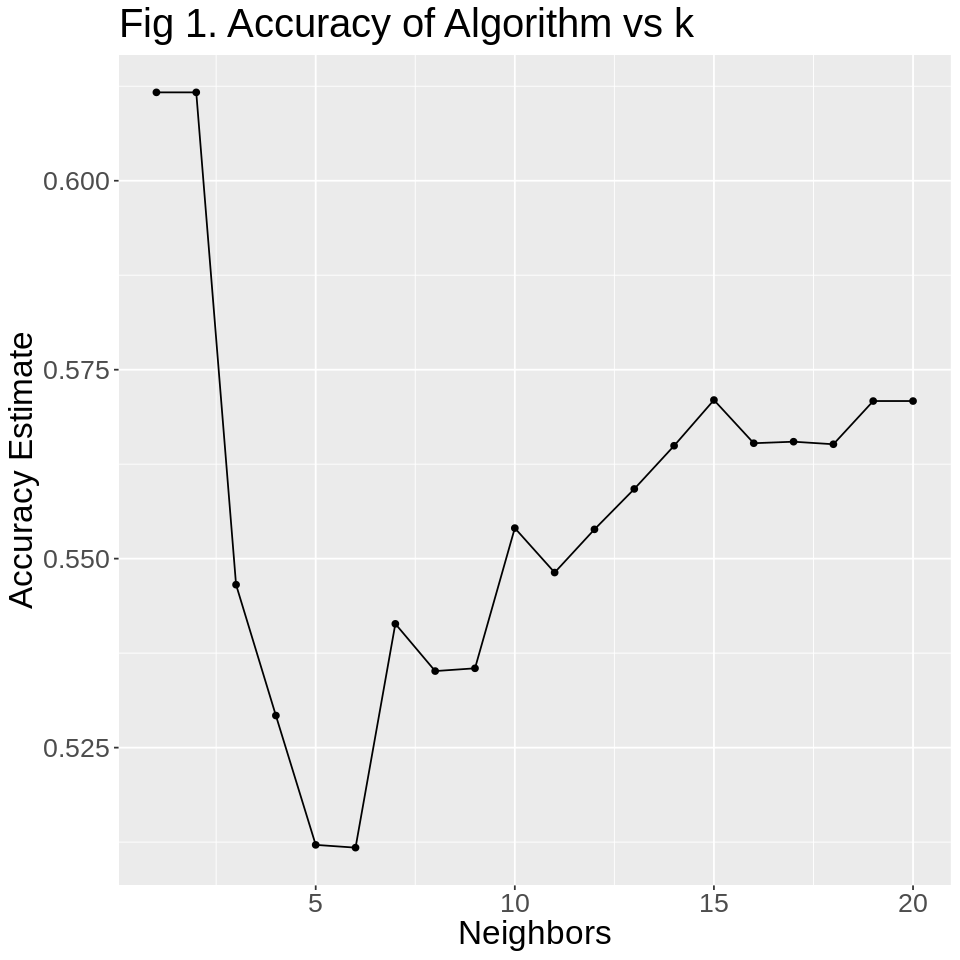

In [34]:
set.seed(9999) #TODO: Added this because of very different plots per run

options(repr.plot.width=8, repr.plot.height=8)

# wrange data furthur to remove id
glass_data <- glass_data_processed |> select(-id)

# split dataset into training and testing data
# TODO: check if appropriate proportion?
glass_split <- initial_split(glass_data, prop = 0.8, strata=glass_type)
glass_train <- training(glass_split)
glass_test <- testing(glass_split)

# Cross validation and tuning to find best k
glass_spec <- nearest_neighbor(weight_func="rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# TODO: not exactly sure if i should upsample here to balance data, maybe ask TA?
glass_recipe <- recipe(glass_type ~ ., data = glass_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_upsample(glass_type)

# 5-fold cross validation
vfold <- vfold_cv(glass_train, v=5, strata=glass_type)

# neighbors to try
# TODO: what should we try here?
vals <- tibble(neighbors = seq(from=1, to = 20))

knn_results <- workflow() |>
    add_recipe(glass_recipe) |>
    add_model(glass_spec) |>
    tune_grid(resamples = vfold, grid = vals)|>
    collect_metrics()

accuracies <- knn_results |>
    filter(.metric =="accuracy")

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 20)) +
  ggtitle("Fig 1. Accuracy of Algorithm vs k")
accuracy_vs_k
# TODO: might be a good idea to do forward selection to choose a subset of predictors https://datasciencebook.ca/classification2.html#fig:06-fwdsel-3
#       but this is probably overkill for this project

# we might also want to compare our results to the model that always chooses the most common class COMMENT IF THE FOLLOWING DOESN'T MAKES SENSE
# Get the number of neighbors that gave the highest accuracy
best_neighbors <- accuracies$neighbors[which.max(accuracies$mean)]
# Get the accuracy of the KNN model with the best number of neighbors
knn_accuracy <- accuracies$mean[which.max(accuracies$mean)]

# Implementing the Most Common Class model
# Create a table of class counts in the training data
class_counts <- table(glass_train$glass_type)
# Get the class with the highest count
most_common_class <- names(which.max(class_counts))
# Create a vector of predictions for the test data using the most common class
most_common_predictions <- rep(most_common_class, nrow(glass_test))
# Calculate the accuracy of the baseline model
most_common_accuracy <- mean(most_common_predictions == glass_test$glass_type)

accuracy_tbl <- tibble(Model = c("KNN", "Most Common"),
                       Accuracy = c(knn_accuracy, most_common_accuracy)) #!!!
accuracy_tbl


In [45]:
#Using algorithm on test data with k = 1 and creating a confusion matrix
#Not sure how useful this section so feel free to take it out if it doesn't seem to helpful
#I was thinking it might be helpful for the written portion of our report to show where the inaccuracies in our model are primarily coming from
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_neighbors) |> 
            set_engine("kknn") |> 
            set_mode("classification") 

knn_fit <- workflow() |> 
            add_recipe(glass_recipe) |> 
            add_model(knn_spec) |> 
            fit(data = glass_train) 

glass_test_predictions <- predict(knn_fit, glass_test) |> 
                            bind_cols(glass_test) #add predictions into dataset 

glass_test_predictions |> 
    metrics(truth = glass_type, estimate = .pred_class) |> 
    filter(.metric == "accuracy") #diff value than above cuz no cross validation

#Confusion matrix
confusion <- glass_test_predictions |> 
             conf_mat(truth = glass_type, estimate = .pred_class) 
confusion
#We can directly see that glass types with fewer observations have more unpredictable 
#accuracies, but generally have lower accuracies
#The concern with having certain glass types overrepresented in dataset is that they would skew results of predictions towards them. Even though 
#building_windows_float_processed and building_windows_non_float_processed are the most represented, not all of the largest errors come in these categories. 

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.6590909


                                      Truth
Prediction                             building_windows_float_processed
  building_windows_float_processed                                    9
  building_windows_non_float_processed                                1
  vehicle_windows_float_processed                                     4
  containers                                                          0
  tableware                                                           0
  headlamps                                                           0
                                      Truth
Prediction                             building_windows_non_float_processed
  building_windows_float_processed                                        2
  building_windows_non_float_processed                                    9
  vehicle_windows_float_processed                                         2
  containers                                                              2
  tableware                 

#### Create a visualization of the analysis 

`summarise()` has grouped output by 'glass_type'. You can override using the
`.groups` argument.


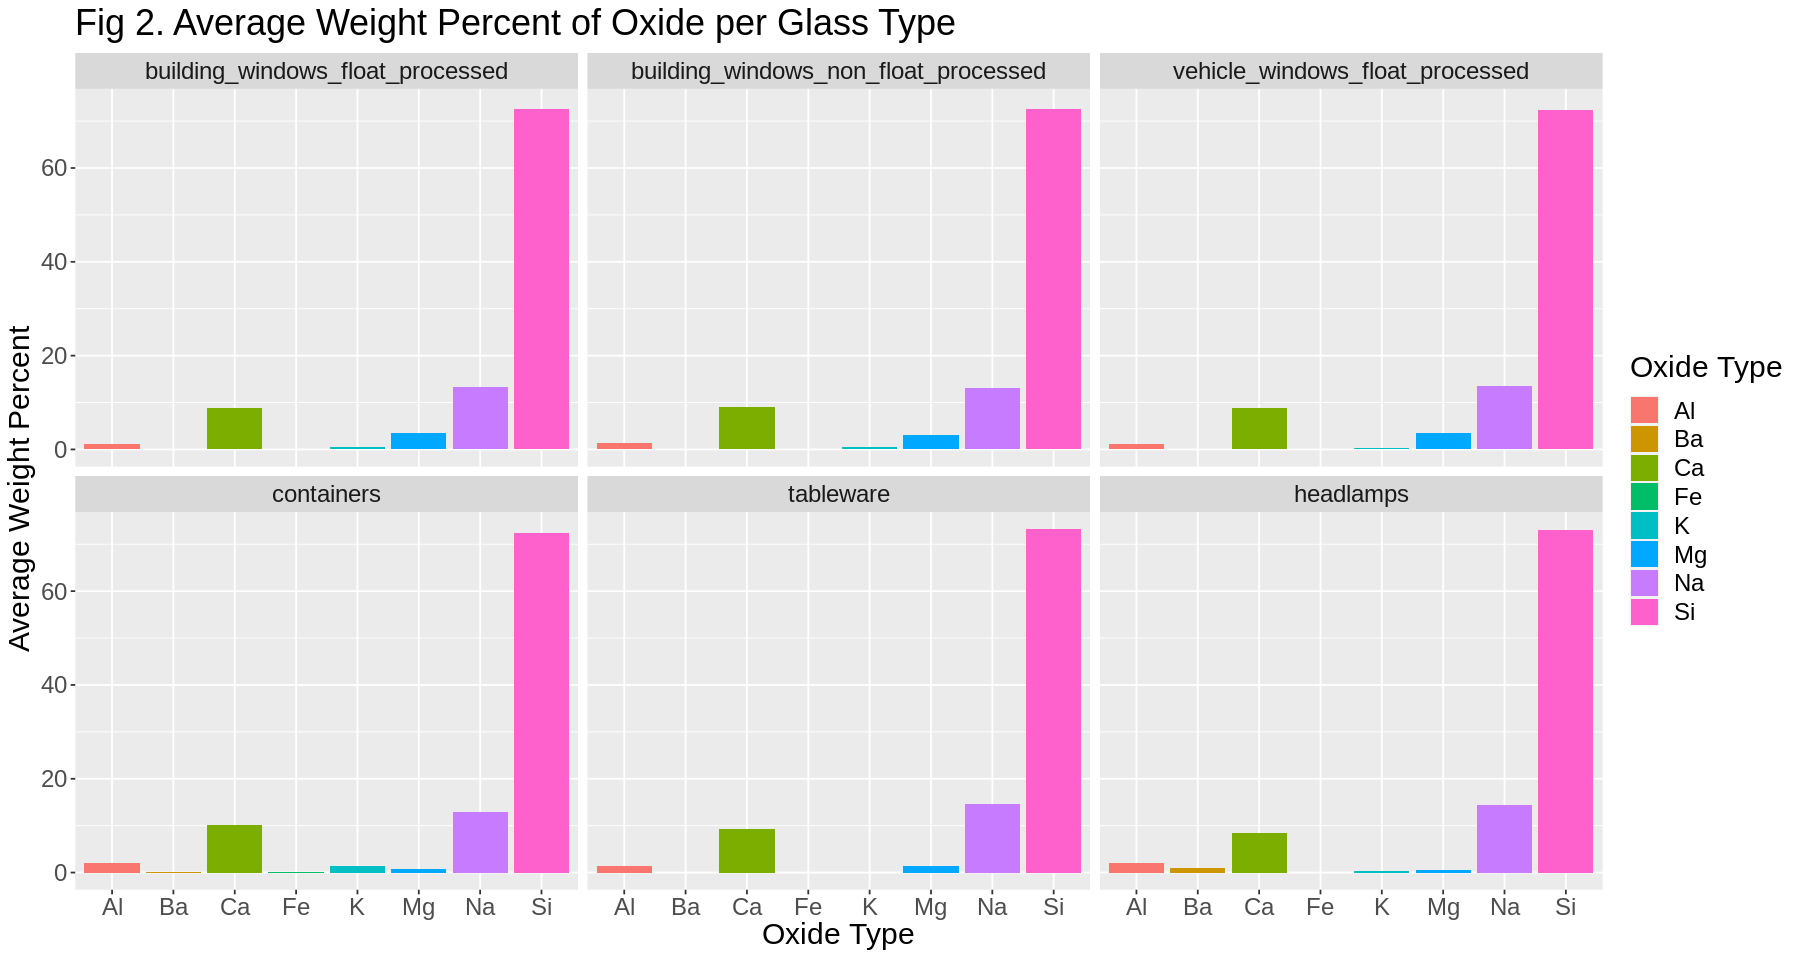

In [35]:
options(repr.plot.width=15, repr.plot.height=8)

glass_visual_data <- glass_data_processed |>
    pivot_longer(cols = Na:Fe, names_to = "oxide_type", values_to = "weight_percent") |>
    group_by(glass_type, oxide_type) |>
    summarise(mean_weight_percent = mean(weight_percent)) |>
    ungroup()

glass_visual_plot <- glass_visual_data |>
    ggplot(aes(x = oxide_type, y = mean_weight_percent, fill = oxide_type)) +
    geom_bar(stat = "identity", position = "dodge") +
    labs(x = "Oxide Type", y = "Average Weight Percent", fill = "Oxide Type") +
    facet_wrap(~glass_type, nrow = 2) +
    theme(text = element_text(size = 18)) +
    ggtitle("Fig 2. Average Weight Percent of Oxide per Glass Type")
glass_visual_plot